# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import os.path
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Visualizations will be shown in the notebook.
%matplotlib inline
import pandas as pd

from sklearn.utils import shuffle
import cv2
import random
from scipy import ndimage
from tqdm import tqdm


# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(test['labels']))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

In [3]:
#Load the signal names to Label the results
signal_names = pd.read_csv("signnames.csv").set_index("ClassId")["SignName"]
signal_names_new = signal_names.reset_index().set_index("SignName")

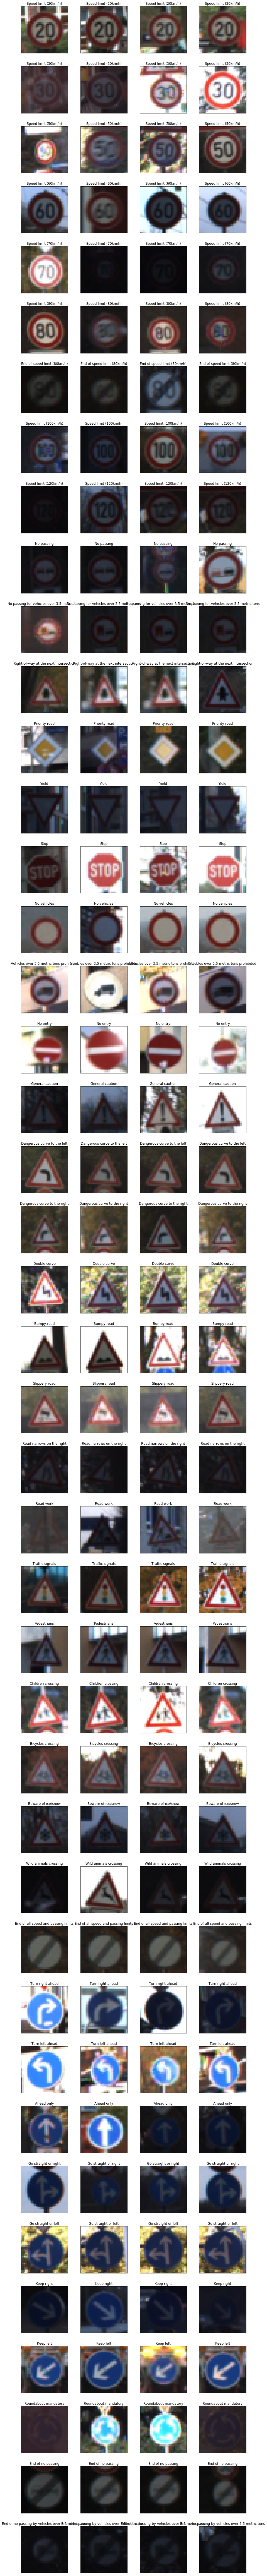

In [4]:
#Ploting samples for each class
def plot_image(ax, img, title=""):
    if img.shape[-1] == 1:
        ax.imshow(img[:,:,0], cmap='Greys_r')
    else:
        ax.imshow(img[:,:,:])            
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

ys = pd.Series(y_valid)
classes = np.unique(y_valid)
rows = classes.shape[0]
cols = 4
size = 3
num_examples = rows * cols    
f, ax = plt.subplots(rows, cols, figsize=(cols*size,rows*size))
f.tight_layout()
ax = ax.ravel()
ax_cnt = 0
for c in classes:
    c_idx = ys[ys==c].index.values
    title = signal_names[c]
    np.random.shuffle(c_idx)
    for i in c_idx[:cols]:            
        plot_image(ax[ax_cnt], X_valid[i,:,:,:], title)
        ax_cnt += 1

Total: 43


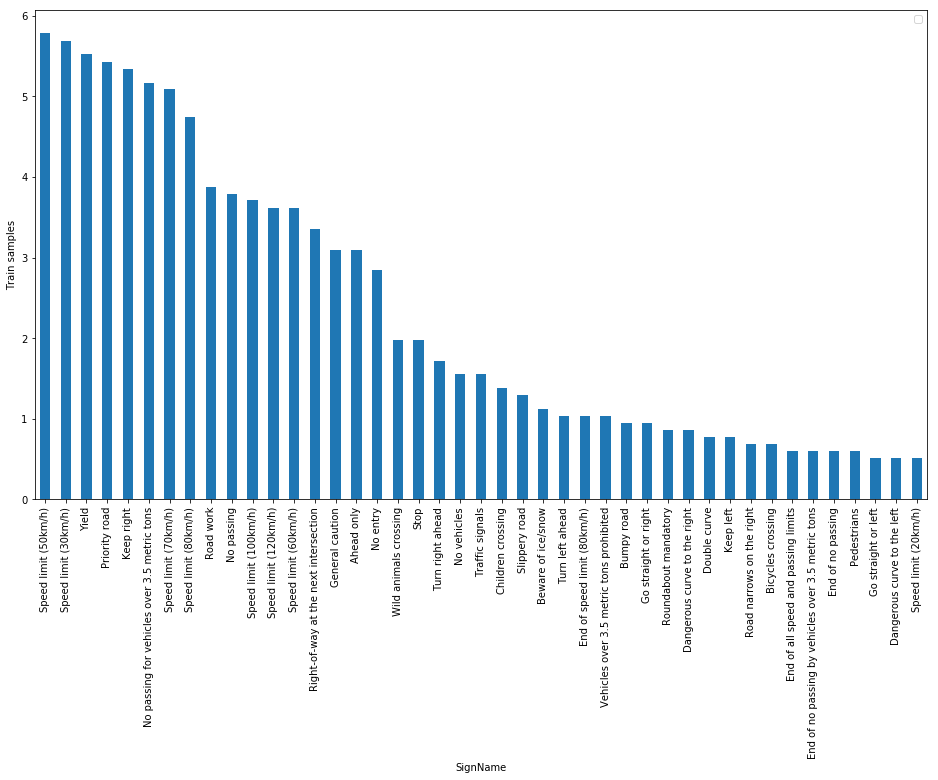

In [5]:
#Visualize the distribution along the classes
s = pd.Series(y_train)
df = pd.DataFrame({
        'counts':s.value_counts()
        ,'percentage':s.value_counts(normalize=True).round(4)*100
    }).join(signal_names).set_index("SignName")
print("Total: {}".format(len(df)))
df.plot.bar(x=df.index, y="percentage", figsize=(16,9))
plt.ylabel("Train samples")
plt.legend([])

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

In [6]:
### Shuffling the data
X_train, y_train = shuffle(X_train, y_train)

# Convert to grayscale and apply histogram equalization
def normalize_image_128(images):
    return (images-128)/128

def normalize_image(image):
    return (image - np.mean(image))/np.std(image)

def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

# Grayscale
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

# Normalizes the data between 0.1 and 0.9 instead of 0 to 255    
def normalize(data):
    return data / 255 * 0.8 + 0.1

# Iterates through grayscale for each image in the data
def preprocess(data):
    gray_images = []
    for image in data:
        gb = cv2.GaussianBlur(image, (5,5), 20.0)
        img = cv2.addWeighted(image, 2, gb, -1, 0)
        gray_images.append(img)
    return np.array(gray_images)

12


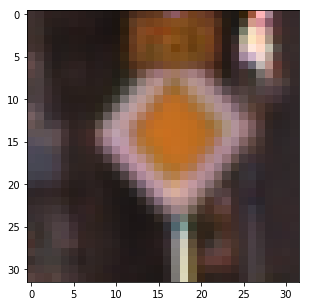

In [7]:
#checking

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(5,5))
plt.imshow(image)
print(y_train[index])

In [8]:
#ROTATE image for data augmentation
def rotate(image):
    image = ndimage.rotate(image, random.randint(-10,10), reshape=False)
    return (image)
    
#AUGMENT > to be improved
# X_training_file_augmented = "./X_training_file_augmented.pkl"
# y_training_file_augmented = "./y_training_file_augmented.pkl"
# save_files = True

# if(os.path.isfile(X_training_file_augmented)):
#     with open(X_training_file_augmented, mode='rb') as f:
#         X_train_augmented = pickle.load(f)

#     with open(y_training_file_augmented, mode='rb') as f:
#         y_train_augmented = pickle.load(f)
#     print("Files Loaded")    
#     save_files = False
    
# if(save_files):
#     print("Creating Augmented data")
#     class_pics = np.bincount(y_train)
#     new_x = []
#     new_y = []
#     max_images = 2000
#     for i in tqdm(range(len(class_pics))):
#         if class_pics[i] < max_images:
#             new = max_images - class_pics[i]
#             pics_in_class = np.where(y_train == i)
#             for j in range(new):
#                 new_x.append(rotate(X_train[pics_in_class][random.randint(0,class_pics[i] - 1)]))
#                 new_y.append(i)
#     X_train_augmented = np.append(X_train, np.array(new_x), axis=0)
#     y_train_augmented = np.append(y_train, np.array(new_y), axis=0)
#     print("Done augmenting data")
#     print("Start Saving aug data")
#     pickle.dump(X_train_augmented, open(X_training_file_augmented, 'wb'))
#     pickle.dump(y_train_augmented, open(y_training_file_augmented, 'wb'))
#     print("Saved.")

In [9]:
#Applying preprocess
X_train = preprocess(X_train)
X_train = normalize_grayscale(X_train)
print("X_train processed")
X_valid = preprocess(X_valid)
X_valid = normalize_grayscale(X_valid)
print("X_valid processed")
X_test = preprocess(X_test)
X_test = normalize_grayscale(X_test)
print("X_test processed")

X_train processed
X_valid processed
X_test processed


### Model Architecture

In [10]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
def LeNet(x):
    mu = 0
    sigma = 0.1
    strides = [1,1,1,1]
    # Conv Layer 1_1. Input = 32x32x3. Output = 32x32x64.
    F_W = tf.Variable(tf.truncated_normal([3,3,3,32], mean=mu, stddev=sigma))
    F_b = tf.Variable(tf.zeros(32))

    conv1_1 = tf.nn.conv2d(x, F_W, strides, 'SAME') + F_b
    conv1_1 = tf.nn.relu(conv1_1)
    
    # Conv Layer 1_2: Input 32x32x64. Output = 32x32x64
    F_W2 = tf.Variable(tf.truncated_normal([3,3,32,32], mean=mu, stddev=sigma))
    F_b2 = tf.Variable(tf.zeros(32))

    conv1_2 = tf.nn.conv2d(conv1_1, F_W2, strides, 'SAME') + F_b2
    conv1_2 = tf.nn.relu(conv1_2)
    
    # Pooling 1. Input = 32x32x64. Output = 16x16x64.
    pool1 = tf.nn.max_pool(conv1_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    # Conv Layer 2_1. Input = 16x16x64. Output = 16x16x128.
    F_W3 = tf.Variable(tf.truncated_normal([3,3,32,64], mean=mu, stddev=sigma))
    F_b3 = tf.Variable(tf.zeros(64))

    conv2_1 = tf.nn.conv2d(pool1, F_W3, strides, 'SAME') + F_b3
    conv2_1 = tf.nn.relu(conv2_1)
    
    # Conv Layer 2_2. Input = 16x16x128. Output = 16x16x128.
    F_W4 = tf.Variable(tf.truncated_normal([3,3,64,64], mean=mu, stddev=sigma))
    F_b4 = tf.Variable(tf.zeros(64))

    conv2_2 = tf.nn.conv2d(conv2_1, F_W4, strides, 'SAME') + F_b4
    conv2_2 = tf.nn.relu(conv2_2)
    
    # Pooling 2. Input = 16x16x128. Output = 8x8x128.
    pool2 = tf.nn.max_pool(conv2_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        
    # Flatten. Input = 8x8x128 = 8192. Output = 128
    F_W5 = tf.Variable(tf.truncated_normal([4096, 128], mean=mu, stddev=sigma))
    F_b5 = tf.Variable(tf.zeros(128))
    fc1 = tf.reshape(pool2, [-1, F_W5.get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, F_W5), F_b5)
    #fc1 = tf.contrib.layers.batch_norm(fc1, center=True, scale=True, is_training=phase, scope='bn1')
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Fully Connected Layer 2. Input = 128. Output = 43
    F_W6 = tf.Variable(tf.truncated_normal([128, n_classes], mean=mu, stddev=sigma))
    F_b6 = tf.Variable(tf.zeros(n_classes))
    fc2 = tf.add(tf.matmul(fc1, F_W6), F_b6)
    #fc2 = tf.contrib.layers.batch_norm(fc2, center=True, scale=True, is_training=phase, scope='bn2')
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)
        
    F_W7 = tf.Variable(tf.truncated_normal([n_classes, n_classes], mean=mu, stddev=sigma))
    F_b7 = tf.Variable(tf.zeros(n_classes))
    logits = tf.add(tf.matmul(fc2, F_W7), F_b7)
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [11]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)
#phase = tf.placeholder(tf.bool)

LEARNING_RATE = 5e-4
EPOCHS = 100
BATCH_SIZE = 128

logits = LeNet(x)

# For decaying learning rate
global_step = tf.Variable(0, trainable=False)
decaying_rate = tf.train.exponential_decay(LEARNING_RATE, global_step, 100000, 0.94, staircase=True)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(decaying_rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in tqdm(range(0, num_examples, BATCH_SIZE)):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [12]:
import time
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    starttime = time.time()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ... {:.2f}s passed".format(i, time.time()-starttime))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 171.11it/s]


EPOCH 0 ... 4.68s passed
Validation Accuracy = 0.416



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 184.20it/s]


EPOCH 1 ... 8.95s passed
Validation Accuracy = 0.675



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 198.90it/s]


EPOCH 2 ... 13.19s passed
Validation Accuracy = 0.802



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 201.19it/s]


EPOCH 3 ... 17.33s passed
Validation Accuracy = 0.846



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 199.47it/s]


EPOCH 4 ... 21.47s passed
Validation Accuracy = 0.879



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 196.11it/s]


EPOCH 5 ... 25.61s passed
Validation Accuracy = 0.908



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 202.36it/s]


EPOCH 6 ... 29.77s passed
Validation Accuracy = 0.918



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 201.77it/s]


EPOCH 7 ... 33.90s passed
Validation Accuracy = 0.933



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 200.04it/s]


EPOCH 8 ... 38.07s passed
Validation Accuracy = 0.931



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 201.77it/s]


EPOCH 9 ... 42.25s passed
Validation Accuracy = 0.937



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 198.33it/s]


EPOCH 10 ... 46.40s passed
Validation Accuracy = 0.951



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 193.93it/s]


EPOCH 11 ... 50.61s passed
Validation Accuracy = 0.953



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 194.47it/s]


EPOCH 12 ... 54.84s passed
Validation Accuracy = 0.962



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 178.10it/s]


EPOCH 13 ... 59.15s passed
Validation Accuracy = 0.965



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 186.17it/s]


EPOCH 14 ... 63.51s passed
Validation Accuracy = 0.969



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 189.71it/s]


EPOCH 15 ... 67.81s passed
Validation Accuracy = 0.969



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 187.67it/s]


EPOCH 16 ... 72.04s passed
Validation Accuracy = 0.969



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 189.20it/s]


EPOCH 17 ... 76.24s passed
Validation Accuracy = 0.973



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 195.01it/s]


EPOCH 18 ... 80.43s passed
Validation Accuracy = 0.973



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 199.47it/s]


EPOCH 19 ... 84.63s passed
Validation Accuracy = 0.969



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 196.11it/s]


EPOCH 20 ... 88.86s passed
Validation Accuracy = 0.973



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 198.90it/s]


EPOCH 21 ... 93.08s passed
Validation Accuracy = 0.974



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 197.77it/s]


EPOCH 22 ... 97.31s passed
Validation Accuracy = 0.973



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 195.01it/s]


EPOCH 23 ... 101.53s passed
Validation Accuracy = 0.975



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 196.66it/s]


EPOCH 24 ... 105.75s passed
Validation Accuracy = 0.977



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 185.18it/s]


EPOCH 25 ... 109.97s passed
Validation Accuracy = 0.973



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 197.21it/s]


EPOCH 26 ... 114.16s passed
Validation Accuracy = 0.974



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 193.93it/s]


EPOCH 27 ... 118.42s passed
Validation Accuracy = 0.981



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 196.11it/s]


EPOCH 28 ... 122.61s passed
Validation Accuracy = 0.979



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 189.20it/s]


EPOCH 29 ... 126.94s passed
Validation Accuracy = 0.981



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 192.32it/s]


EPOCH 30 ... 131.22s passed
Validation Accuracy = 0.975



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 202.36it/s]


EPOCH 31 ... 135.37s passed
Validation Accuracy = 0.978



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 194.47it/s]


EPOCH 32 ... 139.61s passed
Validation Accuracy = 0.976



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 196.66it/s]


EPOCH 33 ... 143.76s passed
Validation Accuracy = 0.977



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 205.33it/s]


EPOCH 34 ... 147.91s passed
Validation Accuracy = 0.979



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 205.33it/s]


EPOCH 35 ... 152.04s passed
Validation Accuracy = 0.982



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 195.01it/s]


EPOCH 36 ... 156.20s passed
Validation Accuracy = 0.980



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 200.61it/s]


EPOCH 37 ... 160.36s passed
Validation Accuracy = 0.983



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 205.94it/s]


EPOCH 38 ... 164.49s passed
Validation Accuracy = 0.976



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 201.19it/s]


EPOCH 39 ... 168.64s passed
Validation Accuracy = 0.979



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 204.13it/s]


EPOCH 40 ... 172.80s passed
Validation Accuracy = 0.979



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 200.04it/s]


EPOCH 41 ... 176.96s passed
Validation Accuracy = 0.980



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 196.66it/s]


EPOCH 42 ... 181.18s passed
Validation Accuracy = 0.979



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 195.56it/s]


EPOCH 43 ... 185.38s passed
Validation Accuracy = 0.982



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 193.39it/s]


EPOCH 44 ... 189.59s passed
Validation Accuracy = 0.986



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 203.54it/s]


EPOCH 45 ... 193.80s passed
Validation Accuracy = 0.979



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 196.11it/s]


EPOCH 46 ... 197.95s passed
Validation Accuracy = 0.982



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 205.94it/s]


EPOCH 47 ... 202.16s passed
Validation Accuracy = 0.978



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 193.39it/s]


EPOCH 48 ... 206.33s passed
Validation Accuracy = 0.978



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 201.19it/s]


EPOCH 49 ... 210.50s passed
Validation Accuracy = 0.981



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 189.71it/s]


EPOCH 50 ... 214.72s passed
Validation Accuracy = 0.987



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 201.19it/s]


EPOCH 51 ... 219.01s passed
Validation Accuracy = 0.983



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 205.33it/s]


EPOCH 52 ... 223.21s passed
Validation Accuracy = 0.980



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 201.77it/s]


EPOCH 53 ... 227.37s passed
Validation Accuracy = 0.982



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 191.27it/s]


EPOCH 54 ... 231.62s passed
Validation Accuracy = 0.979



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 190.75it/s]


EPOCH 55 ... 235.83s passed
Validation Accuracy = 0.984



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 197.21it/s]


EPOCH 56 ... 240.06s passed
Validation Accuracy = 0.979



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 196.11it/s]


EPOCH 57 ... 244.25s passed
Validation Accuracy = 0.984



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 190.75it/s]


EPOCH 58 ... 248.46s passed
Validation Accuracy = 0.982



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 193.39it/s]


EPOCH 59 ... 252.74s passed
Validation Accuracy = 0.980



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 205.94it/s]


EPOCH 60 ... 256.93s passed
Validation Accuracy = 0.982



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 191.27it/s]


EPOCH 61 ... 261.10s passed
Validation Accuracy = 0.987



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 200.04it/s]


EPOCH 62 ... 265.28s passed
Validation Accuracy = 0.979



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 197.77it/s]


EPOCH 63 ... 269.46s passed
Validation Accuracy = 0.987



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 193.93it/s]


EPOCH 64 ... 273.70s passed
Validation Accuracy = 0.985



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 197.77it/s]


EPOCH 65 ... 277.87s passed
Validation Accuracy = 0.984



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 190.75it/s]


EPOCH 66 ... 282.05s passed
Validation Accuracy = 0.986



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 197.77it/s]


EPOCH 67 ... 286.35s passed
Validation Accuracy = 0.979



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 180.87it/s]


EPOCH 68 ... 290.57s passed
Validation Accuracy = 0.986



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 185.68it/s]


EPOCH 69 ... 294.90s passed
Validation Accuracy = 0.984



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 187.67it/s]


EPOCH 70 ... 299.18s passed
Validation Accuracy = 0.981



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 196.11it/s]


EPOCH 71 ... 303.41s passed
Validation Accuracy = 0.988



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 191.80it/s]


EPOCH 72 ... 307.60s passed
Validation Accuracy = 0.977



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 190.75it/s]


EPOCH 73 ... 311.79s passed
Validation Accuracy = 0.981



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 201.19it/s]


EPOCH 74 ... 315.96s passed
Validation Accuracy = 0.984



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 199.47it/s]


EPOCH 75 ... 320.13s passed
Validation Accuracy = 0.985



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 199.47it/s]


EPOCH 76 ... 324.31s passed
Validation Accuracy = 0.984



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 189.20it/s]


EPOCH 77 ... 328.48s passed
Validation Accuracy = 0.985



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 195.56it/s]


EPOCH 78 ... 332.61s passed
Validation Accuracy = 0.982



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 200.04it/s]


EPOCH 79 ... 336.75s passed
Validation Accuracy = 0.982



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 201.19it/s]


EPOCH 80 ... 340.96s passed
Validation Accuracy = 0.982



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 191.27it/s]


EPOCH 81 ... 345.19s passed
Validation Accuracy = 0.989



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 202.95it/s]


EPOCH 82 ... 349.35s passed
Validation Accuracy = 0.988



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 192.32it/s]


EPOCH 83 ... 353.59s passed
Validation Accuracy = 0.988



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 196.11it/s]


EPOCH 84 ... 357.84s passed
Validation Accuracy = 0.990



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 192.86it/s]


EPOCH 85 ... 362.09s passed
Validation Accuracy = 0.983



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 195.01it/s]


EPOCH 86 ... 366.29s passed
Validation Accuracy = 0.983



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 193.93it/s]


EPOCH 87 ... 370.49s passed
Validation Accuracy = 0.988



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 200.04it/s]


EPOCH 88 ... 374.68s passed
Validation Accuracy = 0.988



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 201.19it/s]


EPOCH 89 ... 378.88s passed
Validation Accuracy = 0.989



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 201.77it/s]


EPOCH 90 ... 383.08s passed
Validation Accuracy = 0.988



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 200.04it/s]


EPOCH 91 ... 387.26s passed
Validation Accuracy = 0.978



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 195.56it/s]


EPOCH 92 ... 391.40s passed
Validation Accuracy = 0.983



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 204.13it/s]


EPOCH 93 ... 395.53s passed
Validation Accuracy = 0.984



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 199.47it/s]


EPOCH 94 ... 399.73s passed
Validation Accuracy = 0.989



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 197.77it/s]


EPOCH 95 ... 403.88s passed
Validation Accuracy = 0.986



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 198.33it/s]


EPOCH 96 ... 408.01s passed
Validation Accuracy = 0.989



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 197.77it/s]


EPOCH 97 ... 412.18s passed
Validation Accuracy = 0.986



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 195.56it/s]


EPOCH 98 ... 416.40s passed
Validation Accuracy = 0.982



100%|█████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 193.93it/s]


EPOCH 99 ... 420.58s passed
Validation Accuracy = 0.983

Model saved


In [13]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet


100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 173.99it/s]


Test Accuracy = 0.979


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [14]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
import PIL
from PIL import Image

width, height = 32, 32

# read csv as dict
df_signnames = pd.read_csv('./signnames.csv')

test_images = np.zeros((5,32,32,3))
for i in range(5):
    im = Image.open("traffic-signs-data/test-images/"+str(i)+".jpg").resize((32,32), Image.ANTIALIAS)
    test_images[i] = np.array(im)

### Predict the Sign Type for Each Image
### Analyze Performance 
### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [15]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    feed_dict = {x: test_images, y:[33, 17, 5, 14, 35], keep_prob: 1}
    classification = sess.run(tf.argmax(logits,1), feed_dict=feed_dict)
    prob = sess.run(logits, feed_dict=feed_dict)
    top5 = sess.run(tf.nn.top_k(tf.nn.softmax(tf.constant(prob)), k=5))
    
    for i in range(5):
        print(classification[i], df_signnames[df_signnames.ClassId==classification[i]].SignName.values)
        
        top5labels = []
        for j in range(5):
            top5labels.append(df_signnames[df_signnames.ClassId==top5.indices[i][j]].SignName.values.item(0))
    
        print(top5.values[i], top5labels )

INFO:tensorflow:Restoring parameters from .\lenet
33 ['Turn right ahead']
[ 1.  0.  0.  0.  0.] ['Turn right ahead', 'Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)']
17 ['No entry']
[ 1.  0.  0.  0.  0.] ['No entry', 'Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)']
5 ['Speed limit (80km/h)']
[ 1.  0.  0.  0.  0.] ['Speed limit (80km/h)', 'Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)']
14 ['Stop']
[ 1.  0.  0.  0.  0.] ['Stop', 'Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)']
35 ['Ahead only']
[ 1.  0.  0.  0.  0.] ['Ahead only', 'Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)']


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [17]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")